In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Lecture 06 - Tensorflow Multiple Hidden Layer

- Tensorflow
- Moons Dataset
- Decision Boundary
- Loss curve


<img src='../../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align = "left"/>

## Import Statements

In [4]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

## Setup Global Parameters

In [6]:
###----------------
### Some parameters
###----------------

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 100  # number of epochs
ALPHA = 0.001  # learning rate
N_SAMPLES = 1000
BATCH_SIZE = 32
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [7]:
def fn_plot_decision_boundary(model, X, y):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize = (8,5))
    
    # Small increment to create object function surface
    dm = 0.01
    
    # Range of X values (First feature)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    # Range of Y values (Second feature)
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create a grid to evaluate the object function
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    # flatten and stack
    # arrays will be stacked along their last axis after being upgraded to at least 2-D 
    # with 1’s post-pended to the shape (column vectors made out of 1-D arrays)
    XX = np.c_[xx.ravel(), yy.ravel()] 
    
    # list to collect predictions
    y_p = model.predict(XX)
    Z = y_p.argmax(axis=1) 
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k', cmap=plt.cm.bwr)
    ax.set_title('Decision Boundary')

    ax.set_xlabel('A')
    ax.set_ylabel('B')
    plt.show()

## Generate Data Set
<div style="font-family: Arial; font-size:1.2em">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [9]:
X, y = datasets.make_moons(n_samples=N_SAMPLES,
                           noise=NOISE, 
                           shuffle=True, 
                           random_state=RANDOM_STATE)
# X, y = datasets.make_circles(n_samples=N_SAMPLES,
#                            noise=NOISE, 
#                            shuffle=True, 
#                            random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0], dtype=int64))

In [10]:
data_df = pd.DataFrame(X, columns=['A', 'B'])
data_df['target'] = y
data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [12]:
data_df.describe()

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


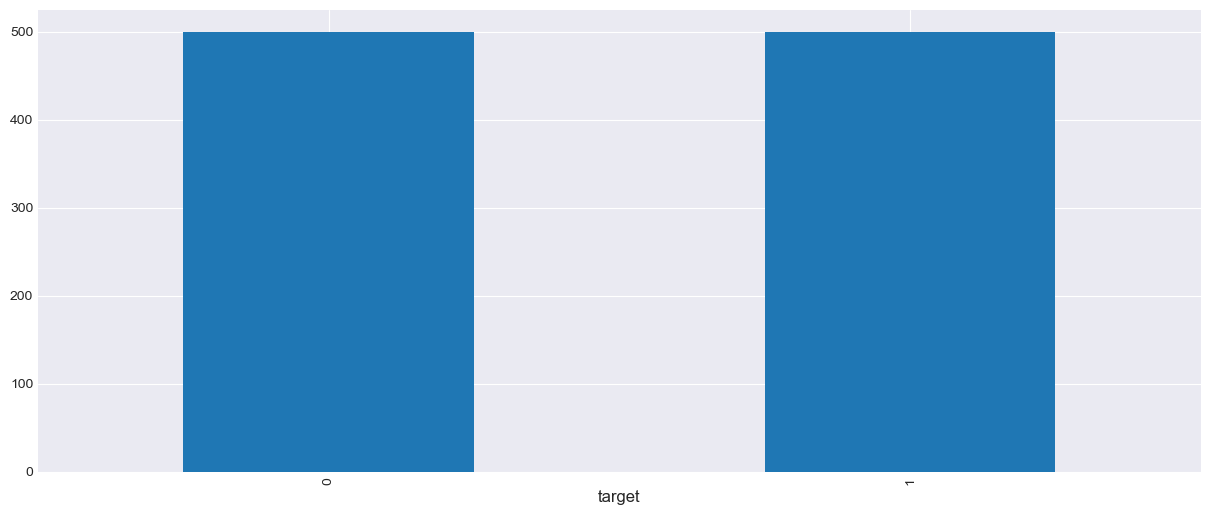

In [13]:
data_df['target'].value_counts().plot(kind = 'bar');

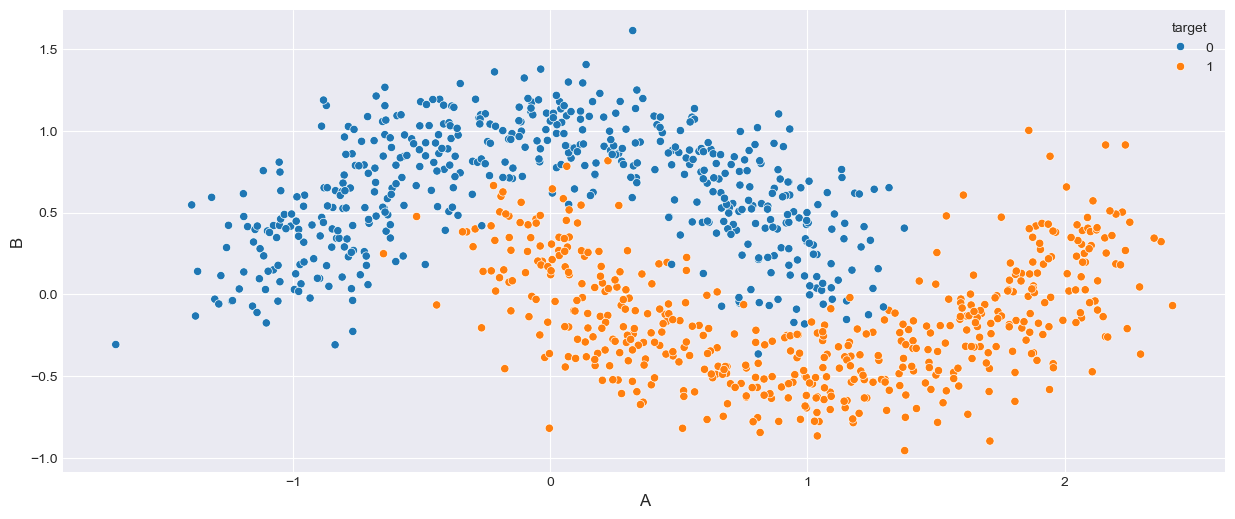

In [14]:
ax = sns.scatterplot(data=data_df, x='A', y='B', hue='target')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

### Define Model

In [17]:
tf.__version__

'2.18.0'

In [18]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),
    tf.keras.layers.Dense(5, activation='relu', name = 'layer1'),
    tf.keras.layers.Dense(5, activation='relu', name = 'layer2'),
    tf.keras.layers.Dense(4, activation='relu', name = 'layer3'),
    tf.keras.layers.Dense(3, activation='relu', name = 'layer4'),
    tf.keras.layers.Dense(2, name = 'output'),
], name = 'FirstModel')

-Functional API - user defined sequence
-EXtend the model Class

In [20]:
X_train[:1].shape

(1, 2)

In [21]:
prediction=model(X_train[:1]).numpy()
prediction.sum()

-0.0076953545

In [22]:
tf.nn.softmax(prediction).numpy()

array([[0.5102953 , 0.48970473]], dtype=float32)

In [23]:
- 2*5 + 5
- 5*5 + 5
- 5*4 +4
- 4*3 +3
- 3*2 +2

-4

In [24]:
model.summary()

Model: "FirstModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 5)                   │              15 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (Dense)                       │ (None, 4)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer4 (Dense)                       │ (None, 3)                   │              15 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92 (368.00 B)

 Trainable params: 92 (368.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
y_train[:1].shape, prediction.shape

((1,), (1, 2))

tf.keras.losses.CategoricalCrossentropy

In [27]:
# y vector is sparse
# no activation in output layer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [28]:
loss_fn(y_train[:1], prediction)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7139527201652527>

In [29]:
model.compile(optimizer = 'adam', loss = loss_fn, metrics = ['accuracy'])

In [30]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6975 - loss: 0.6762 - val_accuracy: 0.7300 - val_loss: 0.6570
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7705 - loss: 0.6552 - val_accuracy: 0.8100 - val_loss: 0.6307
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8406 - loss: 0.6303 - val_accuracy: 0.8300 - val_loss: 0.6007
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8500 - loss: 0.6018 - val_accuracy: 0.8500 - val_loss: 0.5668
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8826 - loss: 0.5536 - val_accuracy: 0.8500 - val_loss: 0.5320
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8820 - loss: 0.5305 - val_accuracy: 0.8650 - val_loss: 0.5014
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8791 - loss: 0.4914 - val_accuracy: 0.8750 - val_loss: 0.4715
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8722 - loss: 0.4767 - val_accuracy: 0.8800 - v

<Axes: >

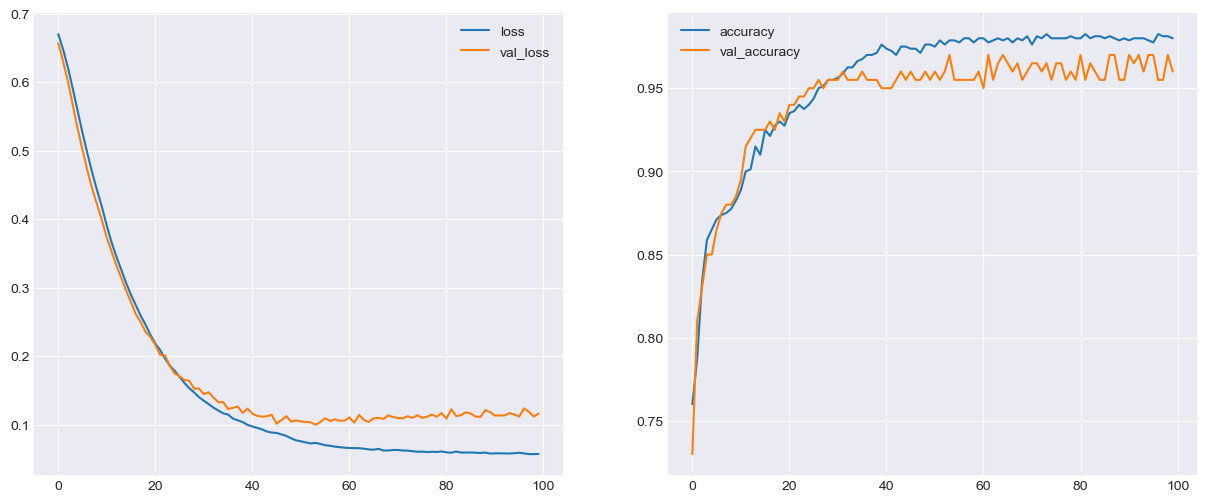

In [31]:
hist_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(1,2)
ax = axes[0]
hist_df.plot(y=['loss', 'val_loss'], ax=ax)
ax = axes[1]
hist_df.plot(y=['accuracy', 'val_accuracy'], ax=ax)

### Training Data

In [33]:
y_pred = model.predict(X_train)

accuracy_score(y_pred=y_pred.argmax(axis=1), y_true=y_train)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


0.9825

In [34]:
cm = confusion_matrix(y_pred=y_pred.argmax(axis=1), y_true=y_train)
cm

array([[391,   9],
       [  5, 395]], dtype=int64)

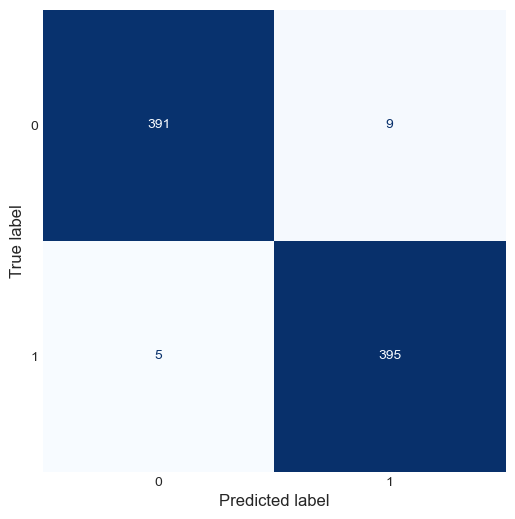

In [35]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot(cmap='Blues', colorbar=False)
plt.grid()
plt.show()

### Testing Data

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Test Accuracy: 0.96


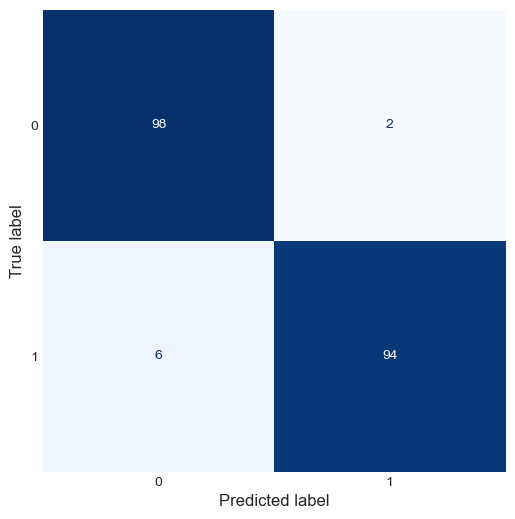

In [37]:
y_pred = model.predict(X_test)


# calculate accuracy
print (f'Test Accuracy: {accuracy_score(y_pred=y_pred.argmax(axis=1), y_true=y_test)}')

# calculate confusion matrix
cm = confusion_matrix(y_pred=y_pred.argmax(axis=1), y_true=y_test)

# plots always look good
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot(cmap='Blues', colorbar=False)
plt.grid()
plt.show()

5529/5529 ━━━━━━━━━━━━━━━━━━━━ 3s 529us/step


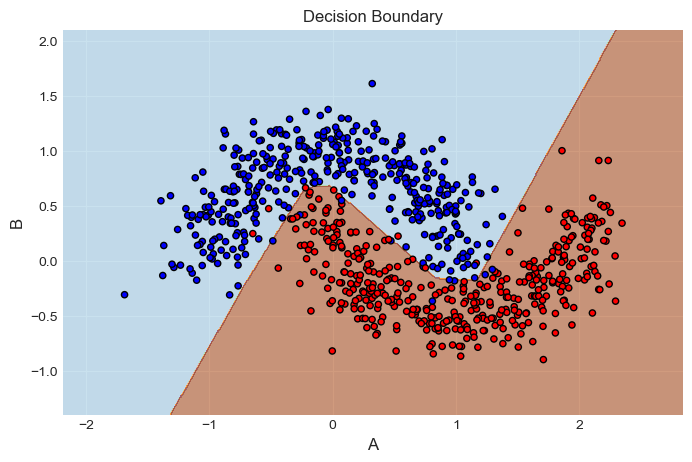

In [38]:
fn_plot_decision_boundary(model, X_train, y_train)